In [69]:
import csv
import multiprocessing as mp
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

# Problem 1

In [70]:
mnist_data = scipy.io.loadmat('data/mnist_data/images.mat')
mnist_data = np.rollaxis(mnist_data['images'], 2, 0).reshape((60000, 28 * 28))

In [71]:
def kmeans(X, k):
    n = X.shape[0]
    y = np.empty(n, dtype=int)
    y.fill(-1)
    
    cent_ind = np.random.choice(np.arange(n), k, replace=False)
    centroids = X[cent_ind].copy().astype(dtype=np.double)
    
    dists = np.empty(n, dtype=np.double)
    dists.fill(np.double('+inf'))
    
    def update_labels():
        updated = False
        for i in range(n):
            new_dists = np.linalg.norm(X[i] - centroids, axis=1)
            min_ind = new_dists.argmin()
            if min_ind != y[i] and new_dists[min_ind] < dists[i]:
                y[i] = min_ind
                dists[i] = new_dists[min_ind]
                updated = True
        return updated
            
    def update_centroids():
        centroids.fill(0)
        for i in range(n):
            centroids[y[i]] += X[i]
        hist = np.bincount(y)
        for i in range(k):
            centroids[i] /= hist[i]
            
    def distortion():
        return dists.dot(dists)
    
    while update_labels():
        print(end='.')
        update_centroids()
    print('Done.')
    
    return distortion(), centroids, y

Running k-means for k = 5...
.................................................Done.
Run = 1, distortion = 238104842877.39496
..................................Done.
Run = 2, distortion = 231145645179.5546
.............................Done.
Run = 3, distortion = 241346360132.02582
.................................Done.
Run = 4, distortion = 229270970036.37332


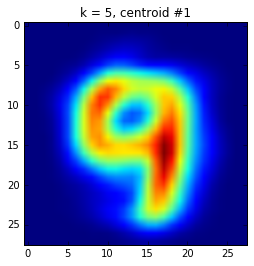

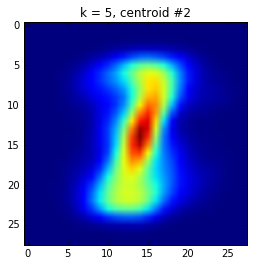

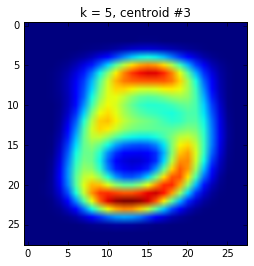

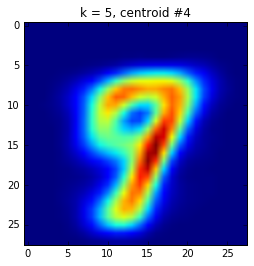

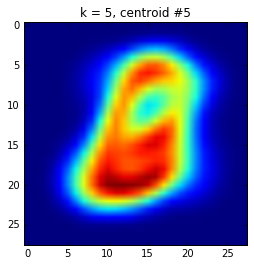

Running k-means for k = 10...
.............................................Done.
Run = 1, distortion = 213929760423.28842
..................................Done.
Run = 2, distortion = 215518284109.39874
.....................................Done.
Run = 3, distortion = 216801878944.61127
................................................Done.
Run = 4, distortion = 216405176806.87872


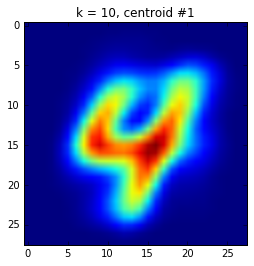

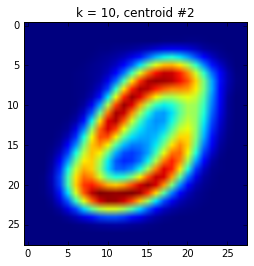

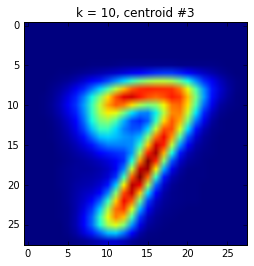

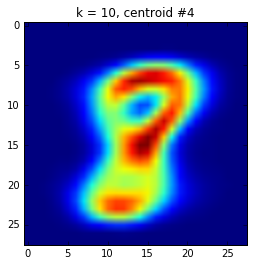

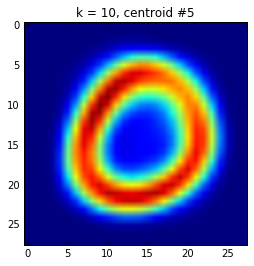

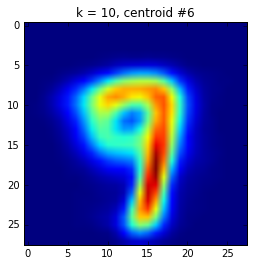

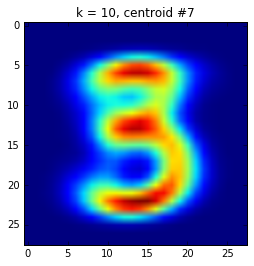

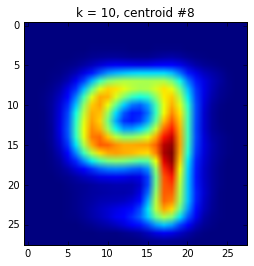

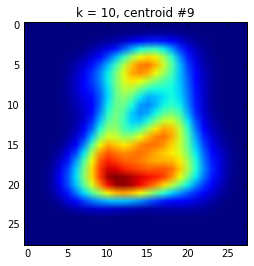

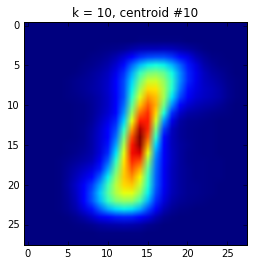

Running k-means for k = 20...
...........................................Done.
Run = 1, distortion = 192293338519.20465
...............................Done.
Run = 2, distortion = 188748967133.9897
...............................................................................Done.
Run = 3, distortion = 193513740327.72595
................................Done.
Run = 4, distortion = 195140321198.011


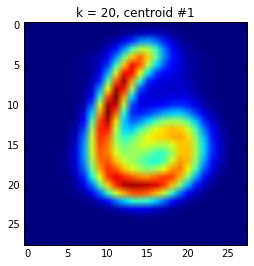

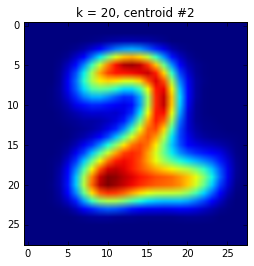

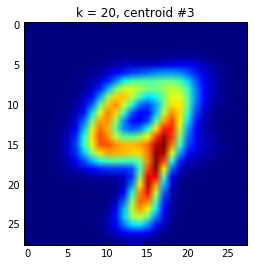

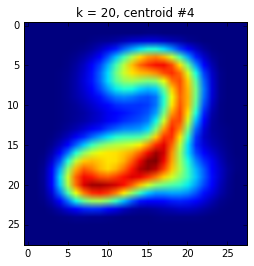

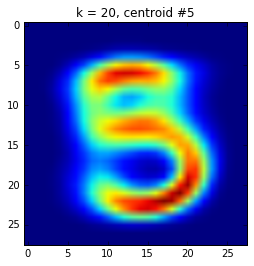

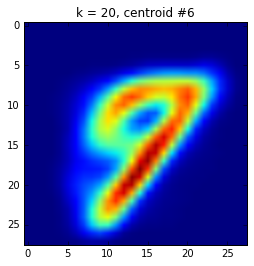

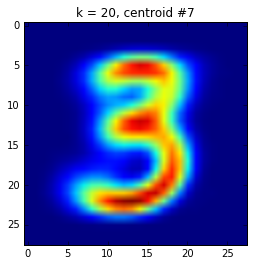

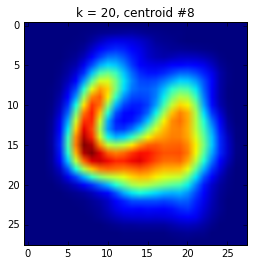

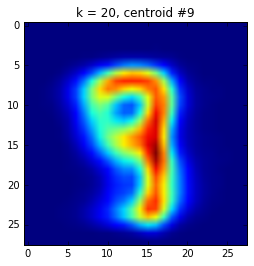

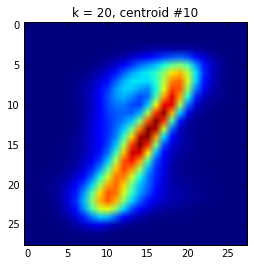

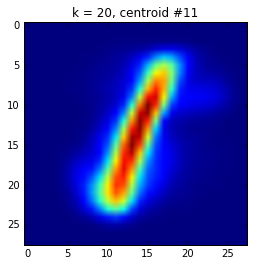

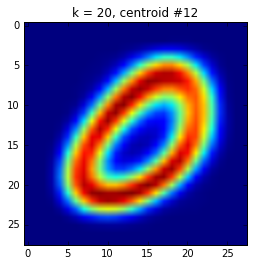

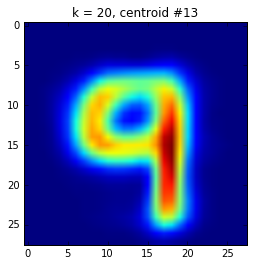

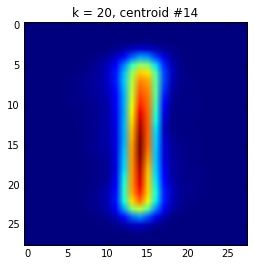

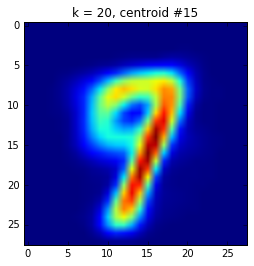

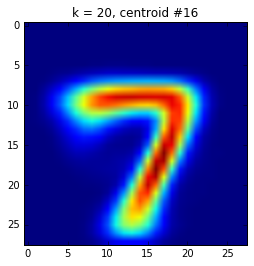

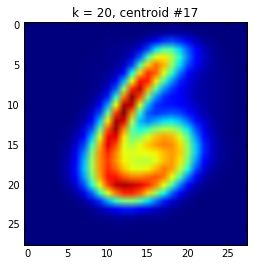

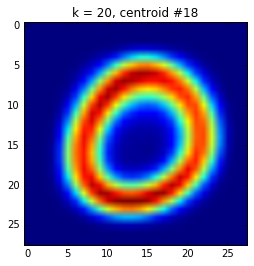

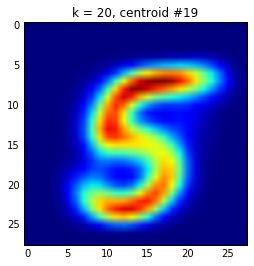

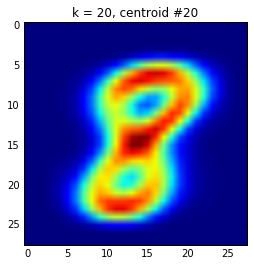

In [72]:
for k in (5, 10, 20):
    print('Running k-means for k = {}...'.format(k))
    
    distortion, centroids = np.double('+inf'), None
    for i in range(4):
        d, c, _ = kmeans(mnist_data, k)
        assert k == c.shape[0]
        
        print('Run = {0}, distortion = {1}'.format(i + 1, d))
        if d < distortion:
            distortion = d
            centroids = c
    
    for i in range(k):
        plt.imshow(centroids[i].reshape((28, 28)))
        plt.title('k = {0}, centroid #{1}'.format(k, i + 1))
        plt.show()

**As we can see, the k-means distortion varies across different runs.**

# Problem 2

## 2.2

In [73]:
joke_train_data = scipy.io.loadmat('data/joke_data/joke_train.mat')['train']
joke_nan_ind = np.isnan(joke_train_data)
joke_train_data[joke_nan_ind] = 0

joke_valid_data = []
with open('data/joke_data/validation.txt', 'r') as f:
    for row in csv.reader(f):
        joke_valid_data.append(tuple(map(int, row)))

joke_queries = []
with open('data/joke_data/query.txt', 'r') as f:
    for row in csv.reader(f):
        joke_queries.append(tuple(map(int, row)))

### Using average rating

In [74]:
hit = 0
for i, j, s in joke_valid_data:
    avg_rating = joke_train_data[:, j - 1].mean()
    if (avg_rating > 0 and s == 1) or (avg_rating <= 0 and s != 1):
        hit += 1

print('Accuracy using average rating: {}'.format(hit / len(joke_valid_data)))

Accuracy using average rating: 0.6203252032520326


### Using k-nearest neighbors

In [75]:
def knn(X, i, k):
    dists = np.linalg.norm(X[i] - X, axis=1)
    return X[np.argsort(dists)[:k]].mean(axis=0)

In [76]:
def knn_runner(k):
    hit = 0
    for i, j, s in joke_valid_data:
        avg_rating = knn(joke_train_data, i - 1, k)[j - 1]
        if (avg_rating > 0 and s == 1) or (avg_rating <= 0 and s != 1):
            hit += 1
    return hit / len(joke_valid_data)
    
with mp.Pool(4) as pool:
    accuracies = pool.map(knn_runner, (10, 100, 1000))

for k, a in zip((10, 100, 1000), accuracies):
    print('Accuracy using {0}-nearest neighbors = {1}'.format(k, a))

Accuracy using 10-nearest neighbors = 0.6420054200542006
Accuracy using 100-nearest neighbors = 0.6886178861788618
Accuracy using 1000-nearest neighbors = 0.6943089430894309


**As we can see, k-nearest neighbors yield slightly better results than naive average rating.**

## 2.3

In [77]:
U, S, VT = np.linalg.svd(joke_train_data)
V = VT.T

In [78]:
for d in (2, 5, 10, 20):
    u = joke_train_data.dot(V[:, :d])  # user vectors
    v = joke_train_data.T.dot(U[:, :d])  # rating vectors
    
    mse = 0
    for i in range(u.shape[0]):
        for j in range(v.shape[0]):
            if not joke_nan_ind[i, j]:
                mse += (u[i].dot(v[j]) - joke_train_data[i, j]) ** 2
                
    hit = 0
    for i, j, s in joke_valid_data:
        pred = u[i - 1].dot(v[j - 1])
        if (pred > 0 and s == 1) or (pred <= 0 and s != 1):
            hit += 1
    accuracy = hit / len(joke_valid_data)

    print('d = {0}, MSE = {1}, accuracy = {2}'.format(d, mse, accuracy))

d = 2, MSE = 6352482479045.252, accuracy = 0.7029810298102981
d = 5, MSE = 7028575080568.219, accuracy = 0.7157181571815718
d = 10, MSE = 7818640882948.638, accuracy = 0.7281842818428185
d = 20, MSE = 9166529444865.428, accuracy = 0.7314363143631436


**I'm including only the output for d = 10 in below for readability, but I have tested d = 2, 5, and 20 also, which didn't work very well.**

In [66]:
beta = 1  # regularization factor

np.seterr(all='raise')

def u_helper(args):
    u, v, i_range = args
    
    for i in i_range:
        A = beta * np.identity(u.shape[1])
        b = np.zeros(u.shape[1])
        
        for j in range(v.shape[0]):
            if not joke_nan_ind[i, j]:
                A += v[j][np.newaxis].T * v[j]
                b += joke_train_data[i, j] * v[j]
        
        u[i] = np.linalg.solve(A, b)
        
    return u[i_range]
        
def v_helper(args):
    u, v, j_range = args
    
    for j in j_range:
        A = beta * np.identity(v.shape[1])
        b = np.zeros(v.shape[1])

        for i in range(u.shape[0]):
            if not joke_nan_ind[i, j]:
                A += u[i][np.newaxis].T * u[i]
                b += joke_train_data[i, j] * u[i]

        v[j] = np.linalg.solve(A, b)

    return v[j_range]
        
for d in (10,):  # 2 and 20 do not work well; 10 seems slightly better than 5
    print('Beginning d = {0}, λ = {1}...'.format(d, beta))
    
    u = joke_train_data.dot(V[:, :d])  # user vectors
    v = joke_train_data.T.dot(U[:, :d])  # rating vectors
    
    def loss():
        L = beta * np.linalg.norm(u) ** 2 + beta * np.linalg.norm(v) ** 2
        for i in range(u.shape[0]):
            for j in range(v.shape[0]):
                if not joke_nan_ind[i, j]:
                    L += (u[i].dot(v[j]) - joke_train_data[i, j]) ** 2
        return L
    
    i_range = np.array_split(np.arange(u.shape[0]), 8)
    j_range = np.array_split(np.arange(v.shape[0]), 8)
    
    with mp.Pool(8) as pool:
        for iteration in range(61):
            u = np.vstack(pool.map(u_helper, [(u, v, i_range[i]) for i in range(8)]))
            v = np.vstack(pool.map(v_helper, [(u, v, j_range[i]) for i in range(8)]))

            if iteration % 10 == 0:
                mse = 0
                for i in range(u.shape[0]):
                    for j in range(v.shape[0]):
                        if not joke_nan_ind[i, j]:
                            mse += (u[i].dot(v[j]) - joke_train_data[i, j]) ** 2

                hit = 0
                for i, j, s in joke_valid_data:
                    pred = u[i - 1].dot(v[j - 1])
                    if (pred > 0 and s == 1) or (pred <= 0 and s != 1):
                        hit += 1
                accuracy = hit / len(joke_valid_data)
                
                print('iteration {0}, loss = {1}, MSE = {2}, accuracy = {3}'
                      .format(iteration, loss(), mse, accuracy))
    
    print('Done.')

Beginning d = 10, λ = 1...
iteration 0, loss = 14898305.960617905, MSE = 11426396.67508796, accuracy = 0.713550135501355
iteration 10, loss = 9956553.282574799, MSE = 9321929.91368581, accuracy = 0.7132791327913279
iteration 20, loss = 9629880.837855654, MSE = 9272909.543076897, accuracy = 0.7203252032520325
iteration 30, loss = 9506972.38753758, MSE = 9256283.823093373, accuracy = 0.7227642276422764
iteration 40, loss = 9442712.40139872, MSE = 9247907.94939051, accuracy = 0.7235772357723578
iteration 50, loss = 9403645.546851726, MSE = 9243081.97823076, accuracy = 0.7238482384823848
iteration 60, loss = 9377664.806438552, MSE = 9240045.326244429, accuracy = 0.7257452574525746
Done.


**As we can see, the MSE is significantly better than before, but the accuracy hasn't really improved much.**

In [67]:
def write_csv(filename):
    with open(filename, 'w') as f:
        f.write('Id,Category\n')
        for csv_id, i, j in joke_queries:
            f.write('{0},{1}\n'.format(csv_id, 1 if u[i - 1].dot(v[j - 1]) > 0 else 0))

In [68]:
write_csv('kaggle_submission.txt')

My Kaggle score is 0.70602.